In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

def errors_from_output_file(output_file, prior=False):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    c = checkpoint["/"].attrs["c"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 1e-2 
    t_obs = checkpoint["/t_obs"][:]
    rmse = checkpoint["/rmse"][:]
    rmse_rel = checkpoint["/rmse_rel"][:]
    
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis, np.newaxis],
                           coords=dict(t=t_obs, nu=np.array([nu]), c=np.array([c])),
                           name="rmse")
    rmse_rel_ds = xr.DataArray(data=rmse_rel[:, np.newaxis, np.newaxis],
                               coords=dict(t=t_obs, nu=np.array([nu]), c=np.array([c])),
                               name="rmse_rel")
    if not prior:
        lml = checkpoint["/lml"][:]
        checkpoint.close()
        
        lml_ds = xr.DataArray(data=lml[:, np.newaxis, np.newaxis],
                              coords=dict(t=t_obs, nu=np.array([nu]), c=np.array([c])),
                              name="lml")
        return (nu, nt_skip), xr.merge([rmse_ds, rmse_rel_ds, lml_ds])
    else:
        checkpoint.close()
        return (nu, nt_skip), xr.merge([rmse_ds, rmse_rel_ds])

In [2]:
from glob import glob

output_files = glob(
    "../outputs/swe-bump/*-posterior-c-*-nt_skip-50-*.h5")

errors_ds = []
for output_file in output_files:
    (nu, nt_skip), e = errors_from_output_file(output_file)
    errors_ds.append(e)

errors_nonlinear = xr.merge(errors_ds)
errors_nonlinear

<xarray.Dataset>
Dimensions:   (t: 400, nu: 7, c: 8)
Coordinates:
  * t         (t) float64 0.01 0.51 1.01 1.51 2.01 ... 198.0 198.5 199.0 199.5
  * nu        (nu) float64 0.0 1e-06 0.0001 0.01 1.0 100.0 1e+04
  * c         (c) float64 5.0 7.0 10.0 11.0 12.0 15.0 20.0 22.0
Data variables:
    rmse      (t, nu, c) float64 6.055e-05 6.055e-05 ... 0.0004158 0.0004159
    rmse_rel  (t, nu, c) float64 0.1217 0.1217 0.1217 ... 2.581 2.579 2.579
    lml       (t, nu, c) float64 -1.163e+08 -1.163e+08 ... -5.485e+09 -5.487e+09

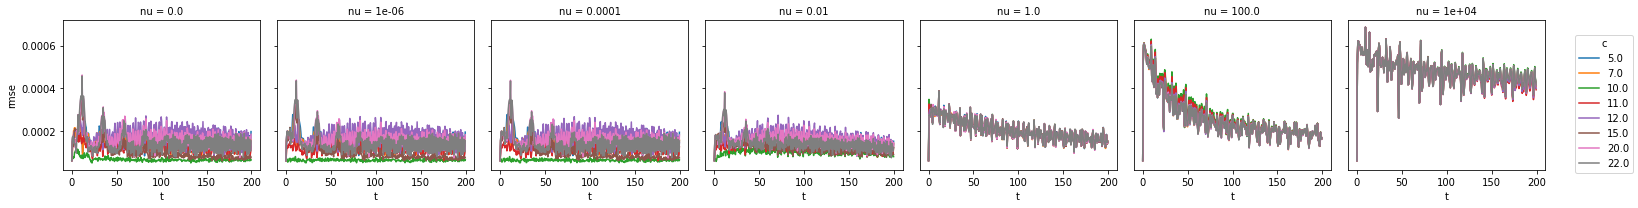

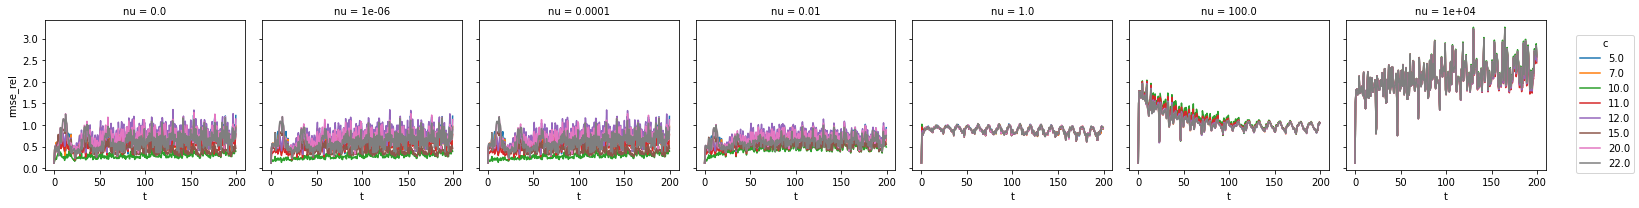

In [3]:
errors_nonlinear.rmse.interpolate_na(dim="t").plot(
    hue="c", col="nu", sharey=True)
plt.show()

errors_nonlinear.rmse_rel.interpolate_na(dim="t").plot(
    hue="c", col="nu", sharey=True)
plt.show()

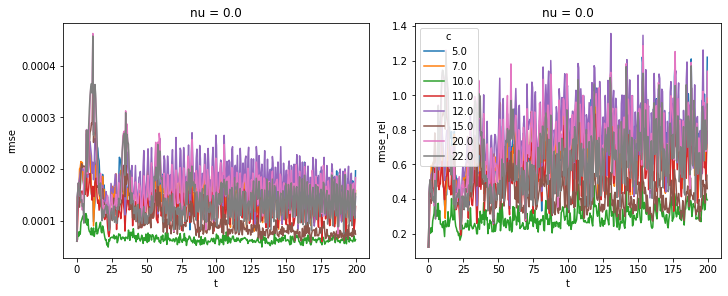

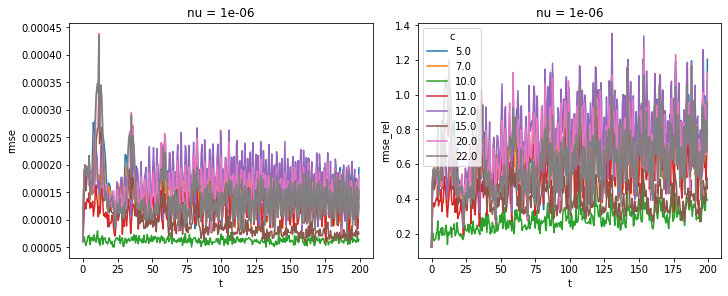

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, constrained_layout=True)
errors_nonlinear.rmse.isel(nu=[0]).interpolate_na(dim="t").plot(
    hue="c", ax=ax[0], add_legend=False)
errors_nonlinear.rmse_rel.isel(nu=[0]).interpolate_na(dim="t").plot(
    hue="c", ax=ax[1], add_legend=True)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, constrained_layout=True)
errors_nonlinear.rmse.isel(nu=[1]).interpolate_na(dim="t").plot(
    hue="c", ax=ax[0], add_legend=False)
errors_nonlinear.rmse_rel.isel(nu=[1]).interpolate_na(dim="t").plot(
    hue="c", ax=ax[1], add_legend=True)
plt.show()

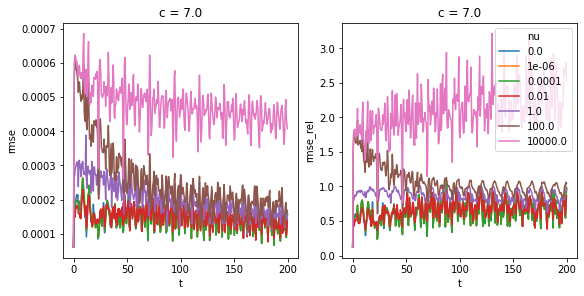

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, constrained_layout=True)
errors_nonlinear.rmse.isel(c=[1]).interpolate_na(dim="t").plot(hue="nu", ax=ax[0], add_legend=False)
errors_nonlinear.rmse_rel.isel(c=[1]).interpolate_na(dim="t").plot(hue="nu", ax=ax[1], add_legend=True)
plt.show()

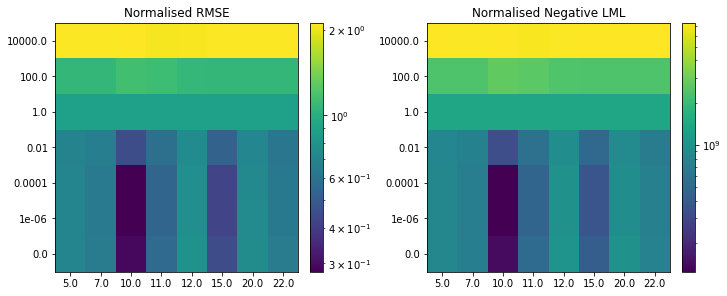

In [6]:
import matplotlib.colors as colors

normalise = True
if normalise:
    total = errors_nonlinear.mean(dim="t")
else:
    total = errors_nonlinear.sum(dim="t")

rmse_array = total.rmse_rel.to_numpy()
lml_array = -total.lml.to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
im = ax[0].pcolormesh(range(len(total.coords["c"].to_numpy())), 
                      range(len(total.coords["nu"].to_numpy())),
                      rmse_array,
                      norm=colors.LogNorm(vmin=rmse_array.min(), 
                                          vmax=rmse_array.max()))
ax[0].set_xticks(range(len(total.coords["c"].to_numpy())), 
                 total.coords["c"].to_numpy())
ax[0].set_yticks(range(len(total.coords["nu"].to_numpy())), 
                 total.coords["nu"].to_numpy())
ax[0].set_title("{s} RMSE".format(s="Normalised" if normalise else ""))
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(range(len(total.coords["c"].to_numpy())), 
                      range(len(total.coords["nu"].to_numpy())),
                      lml_array,
                      norm=colors.LogNorm(vmin=lml_array.min(), 
                                          vmax=lml_array.max()))
ax[1].set_xticks(range(len(total.coords["c"].to_numpy())), 
                 total.coords["c"].to_numpy())
ax[1].set_yticks(range(len(total.coords["nu"].to_numpy())), 
                 total.coords["nu"].to_numpy())
ax[1].set_title("{s} Negative LML".format(s="Normalised" if normalise else ""))
plt.colorbar(im, ax=ax[1])
plt.show()

In [7]:
output_files = glob(
    "../outputs/swe-bump/*-prior-c-*-nt_skip-50-*.h5")

errors_ds = []
for output_file in output_files:
    (nu, nt_skip), e = errors_from_output_file(output_file, prior=True)
    errors_ds.append(e)

errors_prior = xr.merge(errors_ds)
errors_prior

<xarray.Dataset>
Dimensions:   (t: 400, nu: 7, c: 8)
Coordinates:
  * t         (t) float64 0.01 0.51 1.01 1.51 2.01 ... 198.0 198.5 199.0 199.5
  * nu        (nu) float64 0.0 1e-06 0.0001 0.01 1.0 100.0 1e+04
  * c         (c) float64 5.0 7.0 10.0 11.0 12.0 15.0 20.0 22.0
Data variables:
    rmse      (t, nu, c) float64 6.055e-05 6.055e-05 ... 0.0004574 0.0004572
    rmse_rel  (t, nu, c) float64 0.1217 0.1217 0.1217 ... 2.838 2.836 2.836

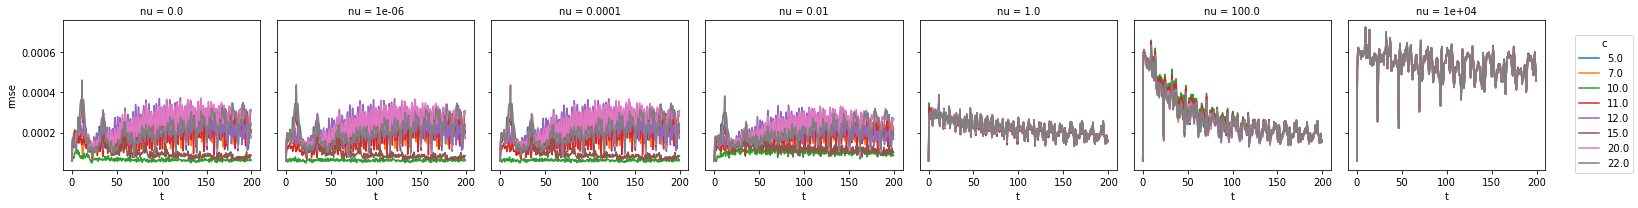

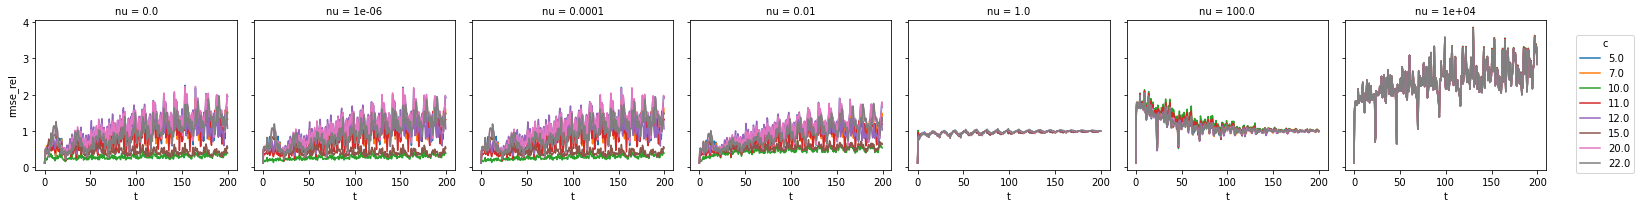

In [8]:
errors_prior.rmse.interpolate_na(dim="t").plot(
    hue="c", col="nu", sharey=True)
plt.show()

errors_prior.rmse_rel.interpolate_na(dim="t").plot(
    hue="c", col="nu", sharey=True)
plt.show()

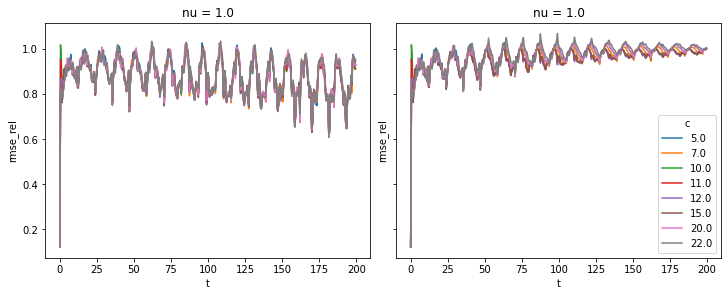

In [9]:
nu = 4
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4), sharey=True)
errors_nonlinear.rmse_rel.isel(nu=nu).interpolate_na(dim="t").plot(
    hue="c", ax=ax[0], add_legend=False)
errors_prior.rmse_rel.isel(nu=nu).interpolate_na(dim="t").plot(
    hue="c", ax=ax[1], add_legend=True)
plt.show()